# Setup & Config

In [13]:
import pandas as pd
from pathlib import Path
import json
import matplotlib.pyplot as plt

file_path = Path("../data/aqi_data_labeled.csv")

# Load small preview to verify path and columns
df = pd.read_csv(file_path, low_memory=False)

print("Columns:", list(df.columns))


Columns: ['Date', 'AQI', 'PM25', 'Ozone', 'NO2', 'SO2', 'CO', 'Windspeed', 'Temperature', 'AQI_Label', 'AQI_Class']


# Parse Data & Clean AQI

In [14]:
# Convert date column to datetime
df["Date"] = pd.to_datetime(df["Date"], format="%m/%d/%y", errors="coerce")

# Convert AQI column to numeric
df["AQI"] = pd.to_numeric(df["AQI"], errors="coerce")

# Drop rows with missing Date or AQI
df = df.dropna(subset=["Date", "AQI"]).reset_index(drop=True)

# Check result 
print("Rows after cleaning:", len(df))


Rows after cleaning: 1095


# Missing Values & Summary

In [15]:
# Show all columns missing counts instead of top 10
missing_counts = df.isna().sum()
print("Missing values per column:\n")
print(missing_counts)

# Summary statistics for numeric columns
print("Numeric summary (first 10 numeric columns):\n")
display(df.describe(include=[float, int]).T.head(10))

# Check label distribution
print("\nLabel distribution (AQI_Label):")
print(df["AQI_Label"].value_counts(normalize=True).rename("ratio").round(3))



Missing values per column:

Date           0
AQI            0
PM25           0
Ozone          0
NO2            0
SO2            0
CO             0
Windspeed      0
Temperature    0
AQI_Label      0
AQI_Class      0
dtype: int64
Numeric summary (first 10 numeric columns):



,count,mean,std,min,25%,50%,75%,max
AQI,1095.0,85.868493,36.355837,31.000000,60.000000,74.000000,101.000000,281.000000
PM25,1095.0,11.006166,4.681787,2.561905,8.278617,10.382698,12.988393,44.270025
Ozone,1095.0,0.031417,0.009073,0.003314,0.024222,0.033065,0.038433,0.054973
NO2,1095.0,13.324591,6.140623,3.399586,8.509096,11.973124,17.398393,37.962878
SO2,1095.0,0.300020,0.211074,-0.033333,0.150764,0.273611,0.420312,2.711458
CO,1095.0,0.338965,0.134244,0.148111,0.232657,0.304081,0.418275,0.913868
Windspeed,1095.0,95.525056,11.454601,47.022000,89.000068,95.924479,102.870433,127.789757
Temperature,1095.0,64.355721,8.804677,44.299242,57.391681,63.461458,71.545766,87.906250
AQI_Class,1095.0,0.336986,0.624494,0.000000,0.000000,0.000000,1.000000,2.000000



Label distribution (AQI_Label):
AQI_Label
Safe       0.746
Caution    0.171
Unsafe     0.083
Name: ratio, dtype: float64


# Feature Engineering

In [16]:
work = df.copy()

# Month feature  for seasonal pattern
work["Month"] = work["Date"].dt.month

# Define pollutant & weather features
feature_cols = ["PM25", "Ozone", "NO2", "SO2", "CO", "Windspeed", "Temperature"]

# Create yesterday and means (7 days) for AQI
work["AQI_Yesterday"] = work["AQI"].shift(1)
work["AQI_Mean7"] = work["AQI"].rolling(7, min_periods=4).mean()

# Regression target: next-day AQI
work["AQI_Nextday"] = work["AQI"].shift(-1)

# Drop empty rows created by yesterday, mean, next day
work = work.dropna().reset_index(drop=True)

# Check result
print("Shape after feature engineering:", work.shape)
work.head()


Shape after feature engineering: (1091, 15)


,Date,AQI,PM25,Ozone,NO2,SO2,CO,Windspeed,Temperature,AQI_Label,AQI_Class,Month,AQI_Yesterday,AQI_Mean7,AQI_Nextday
0,2021-01-04,77,17.684167,0.015154,18.255706,0.313889,0.553226,87.065278,53.570513,Safe,0,1,82.0,105.000000,84.0
1,2021-01-05,84,19.733333,0.011398,21.868150,0.257639,0.562243,83.821759,53.943910,Safe,0,1,77.0,100.800000,90.0
2,2021-01-06,90,21.924583,0.011756,25.787676,0.447917,0.706901,91.346142,57.408654,Safe,0,1,84.0,99.000000,84.0
3,2021-01-07,84,17.660000,0.010896,28.559918,0.570833,0.716111,85.381117,56.274942,Safe,0,1,90.0,96.857143,88.0
4,2021-01-08,88,20.930000,0.017878,26.529823,0.536806,0.660900,88.932407,56.631410,Safe,0,1,84.0,83.142857,96.0


# Time based Train/Test Split

In [17]:
# Get year from Date
work["Year"] = work["Date"].dt.year

# Split: last year as test, previous years as train
year_min, year_max = work["Year"].min(), work["Year"].max()
year_split = year_max - 1

train_df = work[work["Year"] <= year_split].copy()
test_df = work[work["Year"] > year_split].copy()

print(f"Years: {year_min}..{year_max}")
print(f"Train <= {year_split}, Test = {year_max}")

# Show head/tail dates of each split ---
print("\nTrain date range:", train_df["Date"].min(), "→", train_df["Date"].max())
print("Test date range :", test_df["Date"].min(),  "→", test_df["Date"].max())


Years: 2021..2023
Train <= 2022, Test = 2023

Train date range: 2021-01-04 00:00:00 → 2022-12-31 00:00:00
Test date range : 2023-01-01 00:00:00 → 2023-12-30 00:00:00


# Save Processed Datasets

In [18]:
processed_dir = Path("../data/processed")
processed_dir.mkdir(parents=True, exist_ok=True)

# Features: pollutants, weather, AQI yesterday, AQI mean7, month
base_feats = ["Month", "PM25", "Ozone", "NO2", "SO2", "CO", "Windspeed", "Temperature",
              "AQI_Yesterday", "AQI_Mean7"]

print("Total features:", len(base_feats))

# Classification datasets
cls_train = train_df[["Date"] + base_feats + ["AQI_Class"]].copy()
cls_test  = test_df[["Date"] + base_feats + ["AQI_Class"]].copy()

cls_train.to_csv(processed_dir / "processed_classification_train.csv", index=False)
cls_test.to_csv(processed_dir / "processed_classification_test.csv", index=False)

# Regression datasets
reg_train = train_df[["Date"] + base_feats + ["AQI_Nextday"]].copy()
reg_test  = test_df[["Date"] + base_feats + ["AQI_Nextday"]].copy()

reg_train.to_csv(processed_dir / "processed_regression_train.csv", index=False)
reg_test.to_csv(processed_dir / "processed_regression_test.csv", index=False)

print("Files saved in:", processed_dir)

Total features: 10
Files saved in: ..\data\processed


# Save Scheman JSON

In [19]:
cls_schema = {
    "type": "classification",
    "date_col": "Date",
    "target": "AQI_Class",
    "features": base_feats,
    "label_values": sorted(cls_train["AQI_Class"].unique().tolist())
}

reg_schema = {
    "type": "regression_nextday",
    "date_col": "Date",
    "target": "AQI_Nextday",
    "features": base_feats
}

with open(processed_dir / "processed_classification.schema.json", "w") as f:
    json.dump(cls_schema, f, indent=2)
with open(processed_dir / "processed_regression.schema.json", "w") as f:
    json.dump(reg_schema, f, indent=2)



# Check Label Imbalance

In [20]:
# Check class counts and ratios
class_counts = cls_train["AQI_Class"].value_counts()
class_ratio = cls_train["AQI_Class"].value_counts(normalize=True).round(3)

print("Class counts:\n", class_counts)
print("\nClass ratio:\n", class_ratio)

Class counts:
 AQI_Class
0    537
1    135
2     55
Name: count, dtype: int64

Class ratio:
 AQI_Class
0    0.739
1    0.186
2    0.076
Name: proportion, dtype: float64


# Create Weighted Train File + Class Weight JSON

In [21]:
# Give higher weights to labels with fewer samples (inverse frequency)
class_weights = {}
for c, count in class_counts.items():
    class_weights[c] = 1 / count

print("Raw weights:", class_weights)

# Scale weights so that their average is around 1
average = sum(class_weights.values()) / len(class_weights)
for c in class_weights:
    class_weights[c] = round(class_weights[c] / average, 3)

print("\nFinal class weights:", class_weights)

# Add new column to the training data with per-row sample weights
cls_train_weighted = cls_train.copy()
cls_train_weighted["Sample_Weight"] = cls_train_weighted["AQI_Class"].map(class_weights)

# Save weighted training to CSV file
weighted_csv = processed_dir / "processed_classification_train_with_weights.csv"
cls_train_weighted.to_csv(weighted_csv, index=False)
print("\nSaved weighted CSV file:", weighted_csv.name)

# Save class weight mapping to JSON file
weights_json = processed_dir / "class_weights.json"
with open(weights_json, "w") as f:
    json.dump(class_weights, f, indent=2)
print("Saved JSON file:", weights_json.name)


Raw weights: {0: 0.00186219739292365, 1: 0.007407407407407408, 2: 0.01818181818181818}

Final class weights: {0: 0.204, 1: 0.81, 2: 1.987}

Saved weighted CSV file: processed_classification_train_with_weights.csv
Saved JSON file: class_weights.json


# Label Distribution

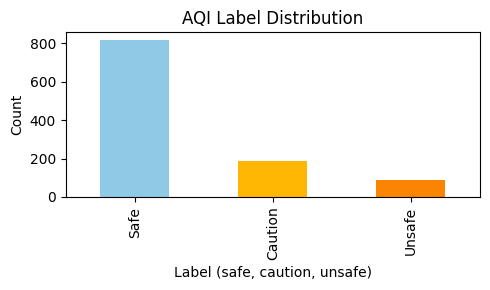

In [22]:
label_col = "AQI_Label"
plt.figure(figsize=(5,3))
df[label_col].value_counts().plot(kind="bar", color=["#8ecae6", "#ffb703", "#fb8500"])
plt.title("AQI Label Distribution")
plt.xlabel("Label (safe, caution, unsafe)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# AQI Time Series (Trend + 7 days mean)

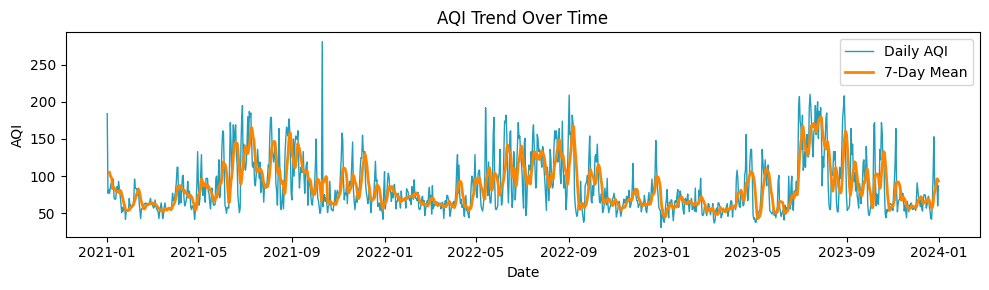

In [23]:
ts = df[["Date","AQI"]].dropna().sort_values("Date").set_index("Date")
plt.figure(figsize=(10,3))
plt.plot(ts.index, ts["AQI"], label="Daily AQI", color="#219ebc", linewidth=1)
plt.plot(ts.index, ts["AQI"].rolling(7, min_periods=4).mean(), label="7-Day Mean", color="#fb8500", linewidth=2)
plt.title("AQI Trend Over Time")
plt.xlabel("Date"); plt.ylabel("AQI")
plt.legend()
plt.tight_layout()
plt.show()


# Correlation Matrix (Numeric Features)

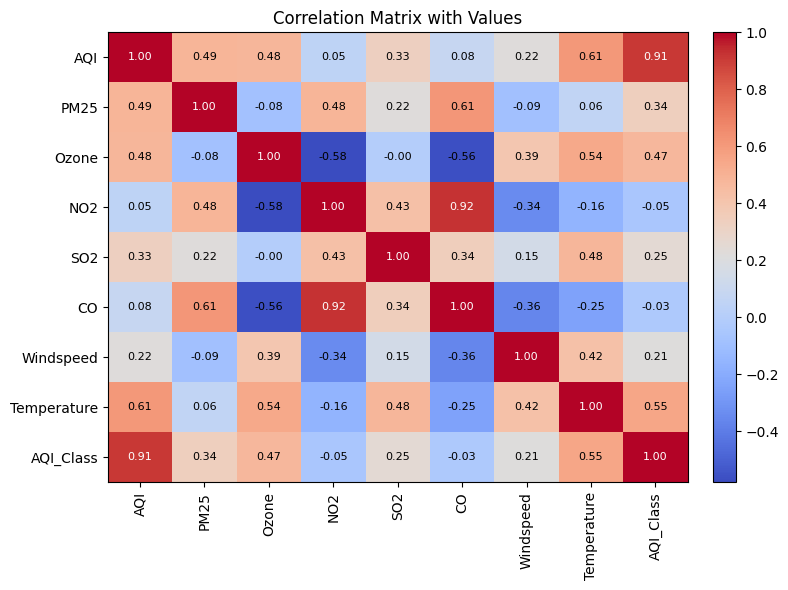

In [24]:
num_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
corr = df[num_cols].corr(numeric_only=True)

plt.figure(figsize=(8,6))
im = plt.imshow(corr.values, cmap="coolwarm", aspect="auto")
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xticks(range(len(num_cols)), num_cols, rotation=90)
plt.yticks(range(len(num_cols)), num_cols)
plt.title("Correlation Matrix with Values")

for i in range(len(num_cols)):
    for j in range(len(num_cols)):
        val = corr.values[i, j]
        plt.text(j, i, f"{val:.2f}", ha="center", va="center",
                 color="black" if abs(val) < 0.7 else "white", fontsize=8)

plt.tight_layout()
plt.show()